In [1]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt

# Load data
def read_mortality_csv(zip_file):
  import io
  import csv
  fields, cities, values = None, [], []
  with io.TextIOWrapper(zip_file.open('data_and_materials/mortality.csv')) as wrap:
    csv_reader = csv.reader(wrap, delimiter=',', quotechar='"')
    fields = next(csv_reader)[1:]
    for row in csv_reader:
      cities.append(row[0])
      values.append(tuple(map(float, row[1:])))
  dtype = np.dtype([(name, float) for name in fields])
  return cities, fields, np.array(values, dtype=dtype).view(np.recarray)

with zipfile.ZipFile("release_statsreview_release1.zip") as zip_file:
  syn_X, syn_y = ( np.loadtxt(zip_file.open('data_and_materials/{}'.format(fname)), delimiter=',') for fname in ['syn_X.csv', 'syn_y.csv'] )
  m_cities, m_fields, m_values = read_mortality_csv(zip_file)

Part (a)

In [2]:
def add_intercept(X):
  return np.concatenate((np.ones_like(X[:,:1]), X), axis=1)

def matrix_inverse_OLS(X, y):
  return linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

import numpy.linalg as linalg
beta_hat = matrix_inverse_OLS(add_intercept(syn_X), syn_y)
print(beta_hat)

[ 1.92960603  1.26397096 -4.59799331]


Part (b)

In [3]:
def loss_fn(beta, X, y):
  # (y - X beta)^T (y - X beta)
  return np.sum(np.square(y - X.dot(beta)))

def loss_grad(beta, X, y):
  # -2*(y - X beta)^T X
  return -2*(y - X.dot(beta)).T.dot(X)

def gradient_step(beta, step_size, X, y):
  loss, grads = loss_fn(beta, X, y), loss_grad(beta, X, y)
  # beta_(i+1) = beta_i - alpha (del f)^T
  beta = beta - step_size * grads.T
  return loss, beta

def gradient_descent(X, y, step_size, precision, max_iter=10000, warn_max_iter=True):
  beta = np.zeros_like(X[0])
  # beta = np.random.randn(len(X[0]))

  losses = [] # Array for recording the value of the loss over the iterations.
  graceful = False
  for _ in range(max_iter):
    beta_last = beta # Save last values of beta for later stopping criterion
    loss, beta = gradient_step(beta, step_size, X, y)
    losses.append(loss)
    # Use the norm of the difference between the new beta and the old beta as a stopping criteria
    if np.sqrt(np.sum(np.square((beta - beta_last)/beta))) < precision:
      graceful = True
      break
  if not graceful and warn_max_iter:
    print("Reached max iterations.")
  return beta, np.array(losses)


BetaHat = [ 1.92960603  1.26397096 -4.5979933 ]


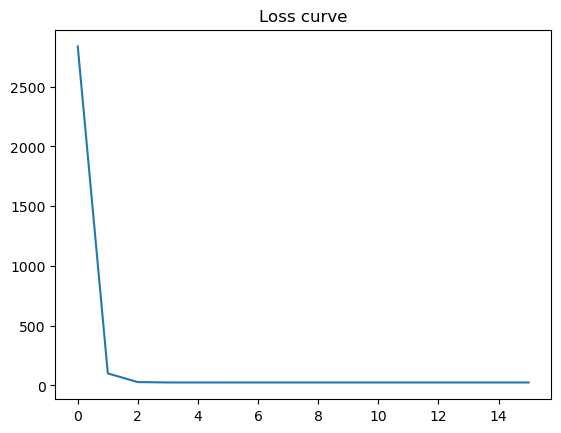

Optimal step size is 0.0042000000000000015 with 11.0 steps


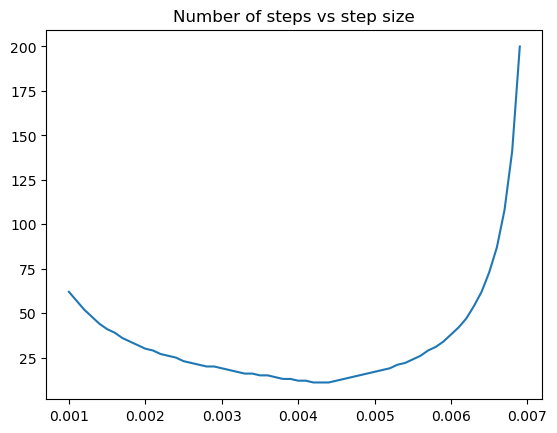

In [4]:
# In my experimentation, it seems a step size of 0.004 converges the fastest
beta_gd, losses = gradient_descent(add_intercept(syn_X), syn_y, 0.004, 1e-8)
print("BetaHat = {}".format(beta_gd))
plt.plot(range(len(losses)), losses)
plt.title("Loss curve")
plt.show()
# Now run a scan over the step size in order to confirm this
step_size_scan_range = np.arange(0.001, 0.007, 0.0001)
step_scan = np.array([ (step_size, len(gradient_descent(add_intercept(syn_X), syn_y, step_size, 1e-6, warn_max_iter=False)[1])) for step_size in step_size_scan_range ]).T # (Feb 17) updated to include intercept feature in scanning the optimal step size
print("Optimal step size is {} with {} steps".format(*step_scan[:, np.argmin(step_scan[1])]))
plt.plot(step_scan[0], step_scan[1])
plt.title("Number of steps vs step size")
plt.show()

Part (c-1)

/var/folders/n2/s7vpqgq50sd0tww3snmdfc7w0000gn/T/ipykernel_13577/2172914725.py:3: RuntimeWarning: overflow encountered in square
  return np.sum(np.square(y - X.dot(beta)))
/var/folders/n2/s7vpqgq50sd0tww3snmdfc7w0000gn/T/ipykernel_13577/2172914725.py:7: RuntimeWarning: overflow encountered in multiply
  return -2*(y - X.dot(beta)).T.dot(X)
/var/folders/n2/s7vpqgq50sd0tww3snmdfc7w0000gn/T/ipykernel_13577/2172914725.py:26: RuntimeWarning: invalid value encountered in true_divide
  if np.sqrt(np.sum(np.square((beta - beta_last)/beta))) < precision:
/var/folders/n2/s7vpqgq50sd0tww3snmdfc7w0000gn/T/ipykernel_13577/2172914725.py:12: RuntimeWarning: invalid value encountered in subtract
  beta = beta - step_size * grads.T


Reached max iterations.
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
nan


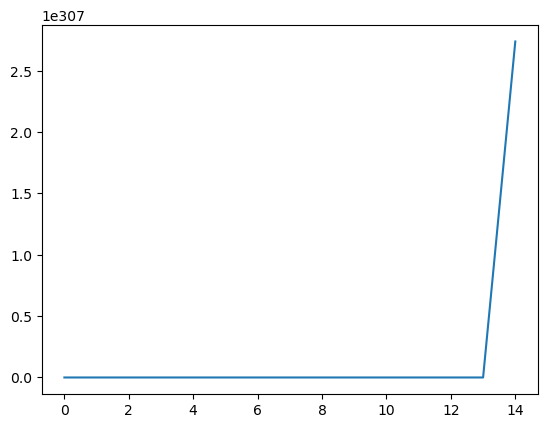

In [5]:
m_y = m_values.Mortality
m_X = np.array([ m_values[f] for f in m_fields if f != 'Mortality']).T # Arrange our X matrix in the same order as the data set, but without the Mortality column.
# Then run the gradient descent, notice the many overflow warnings and the result is all NaNs
m_beta_gd, m_losses = gradient_descent(add_intercept(m_X), m_y, 0.0001, 1e-6, max_iter=100000)
print(m_beta_gd)
print(m_losses[-1])
plt.plot(range(len(m_losses)), m_losses)
plt.show()

Part (c-2)

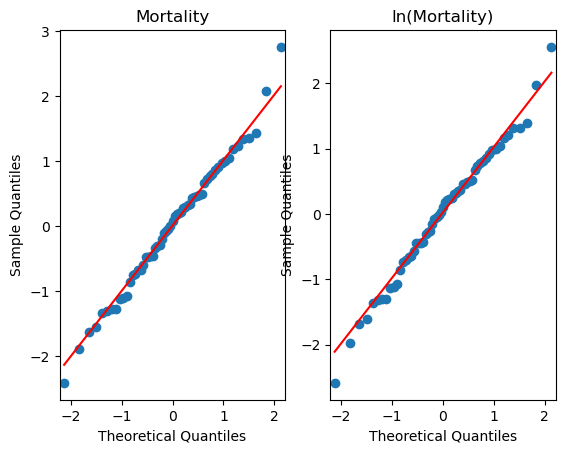

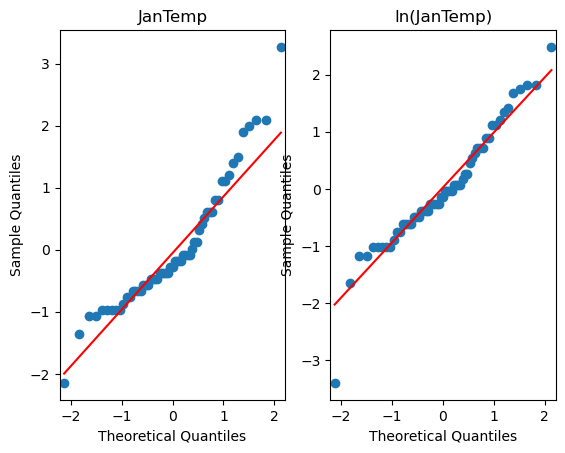

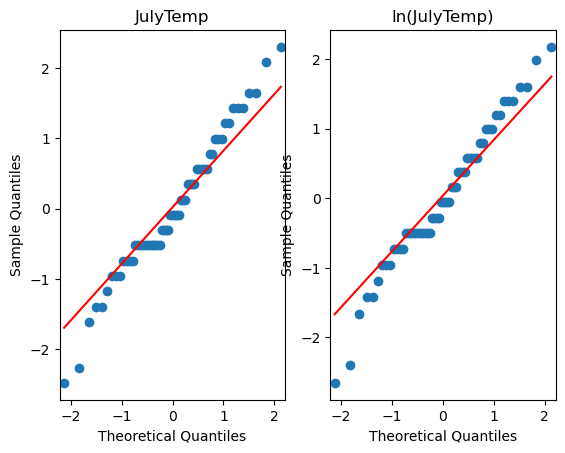

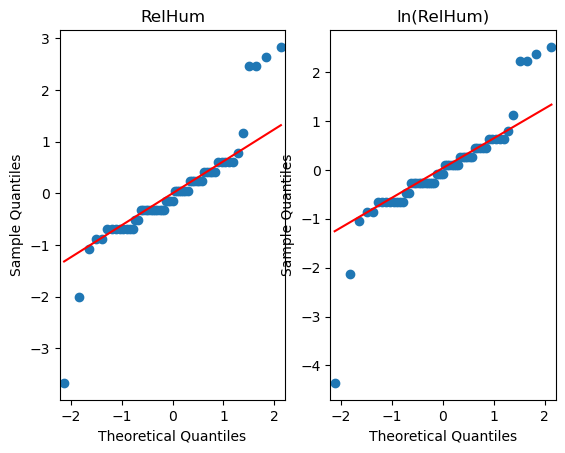

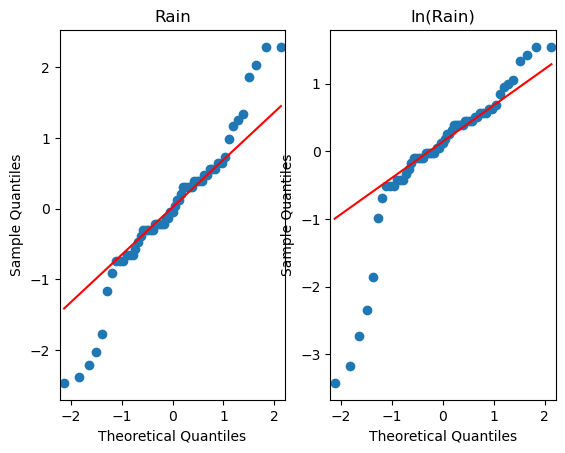

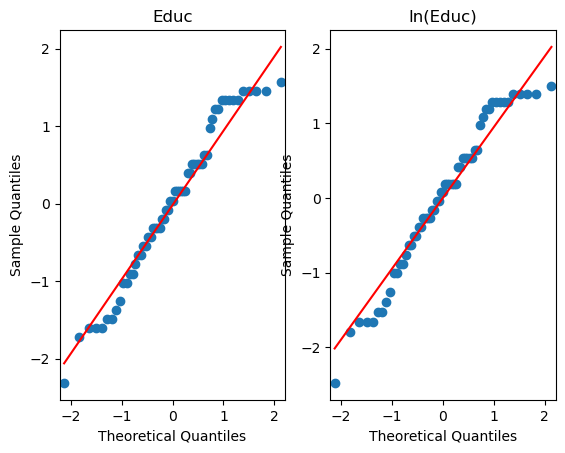

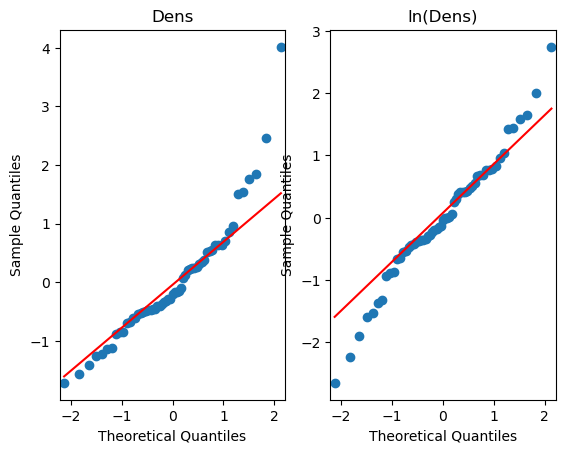

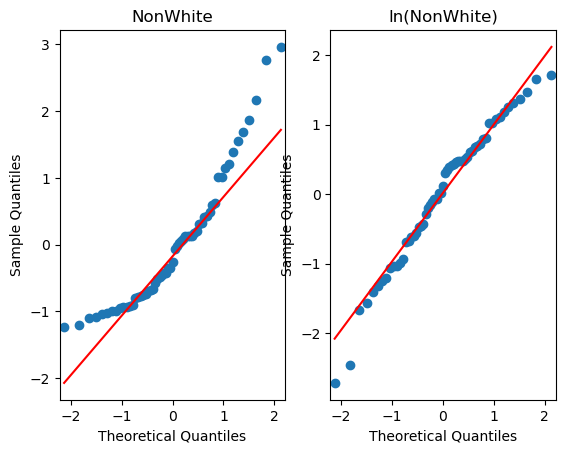

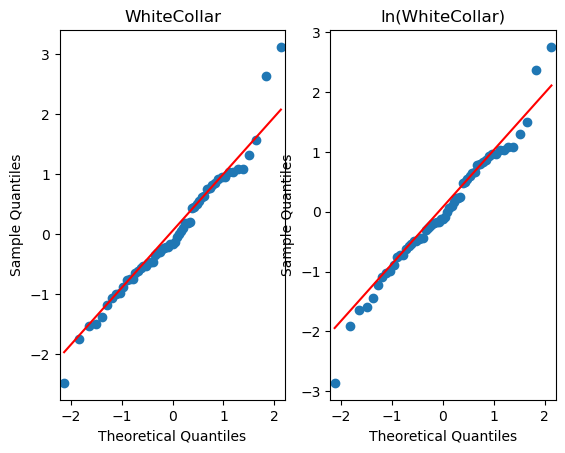

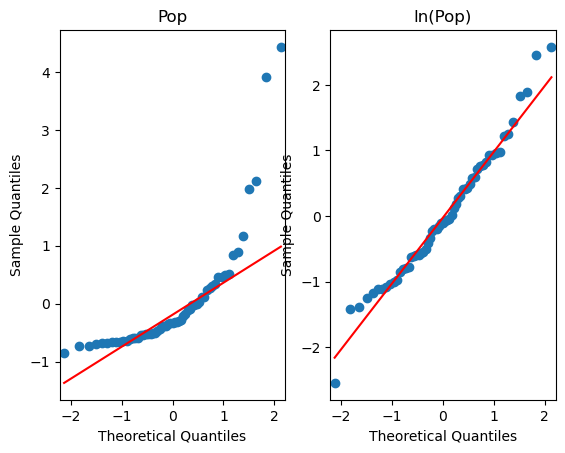

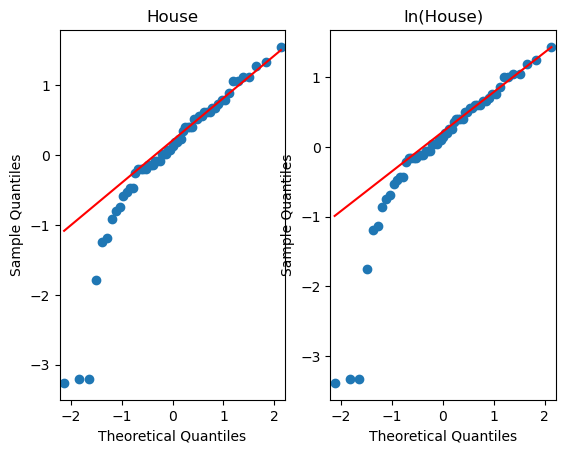

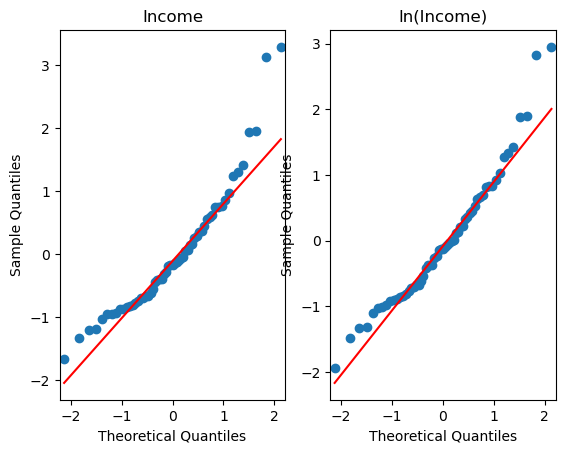

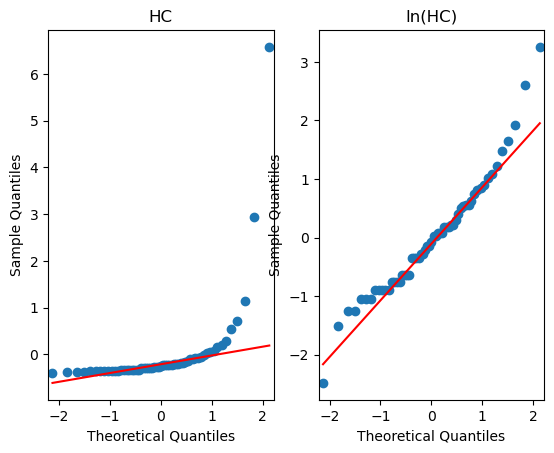

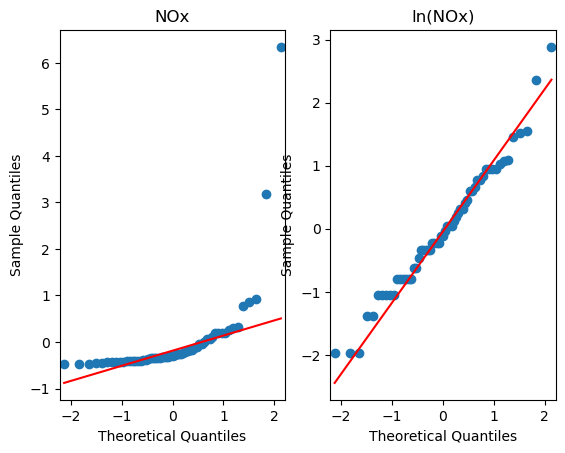

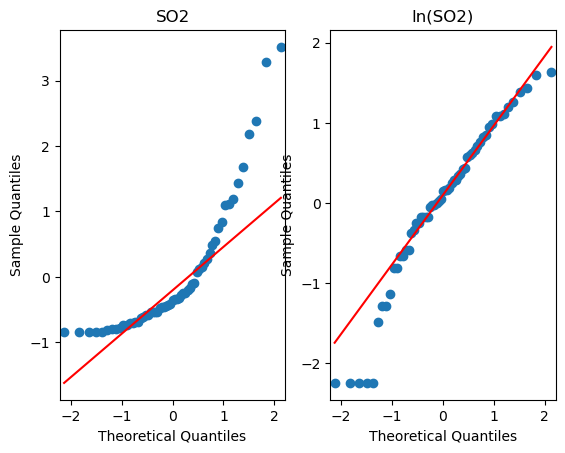

In [6]:
import statsmodels.api as sm
# Here we will make a matrix of Q-Q plots for easy comparison.
for f in m_fields:
  fig = sm.qqplot((m_values[f] - np.mean(m_values[f]))/np.std(m_values[f],ddof = 1), line='q', ax=plt.subplot(1, 2, 1))
  plt.title(f)
  fig = sm.qqplot( (np.log(m_values[f]) -np.mean(np.log(m_values[f]))) / np.std(np.log(m_values[f]), ddof = 1), line='q', ax=plt.subplot(1, 2, 2))
  plt.title("ln({})".format(f))
  plt.show()
# The first thing we can notice from this is the very wide range of values that some variables take

Reached max iterations.
BetaHat = [-3.29042349e-16 -2.34377091e-01 -2.17496828e-01  1.17238925e-02
  1.79754504e-01 -1.50544513e-01  1.08945825e-01  7.64348559e-01
 -1.21202349e-01  8.40325965e-02 -1.11479218e-01 -3.04687337e-02
 -9.96190618e-01  8.81043305e-01  8.61146149e-02]
Final loss value = 13.809259185860332


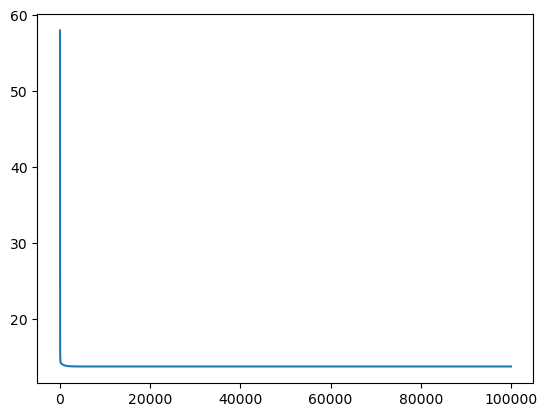

Matrix inverse BetaHat = [-3.19571741e-16 -2.34377091e-01 -2.17496828e-01  1.17238925e-02
  1.79754504e-01 -1.50544513e-01  1.08945825e-01  7.64348559e-01
 -1.21202349e-01  8.40325965e-02 -1.11479218e-01 -3.04687337e-02
 -9.96190618e-01  8.81043305e-01  8.61146149e-02]


In [7]:
# To combat this, we scale these values by their mean and standard deviation.
# Note we also do this for y
m_X_scaled = (m_X - m_X.mean(axis=0))/m_X.std(axis=0, ddof=1)
m_Y_scaled = (m_y - m_y.mean())/m_y.std(ddof=1)
m_X_inter = add_intercept(m_X_scaled)
# Running gradient descent now works.
m_beta_gd, m_losses = gradient_descent(m_X_inter, m_Y_scaled, 0.001, 1e-6, max_iter=100000)
print("BetaHat = {}".format(m_beta_gd))
print("Final loss value = {}".format(m_losses[-1]))
plt.plot(range(len(m_losses)), m_losses)
plt.show()
# As a sanity check, we can also do the matrix inversion 
print("Matrix inverse BetaHat = {}".format(matrix_inverse_OLS(m_X_inter, m_Y_scaled)))

Part (d)

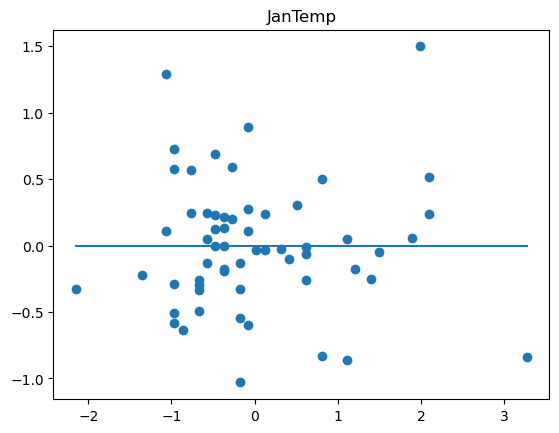

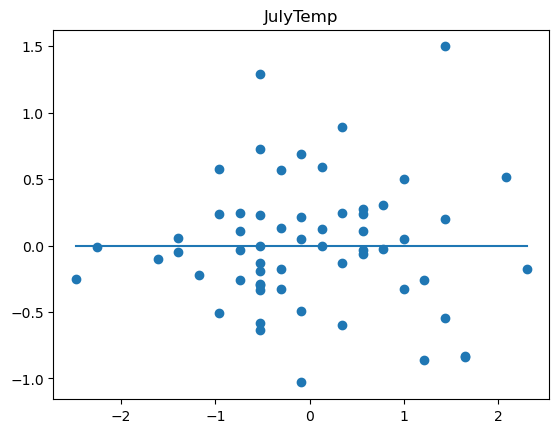

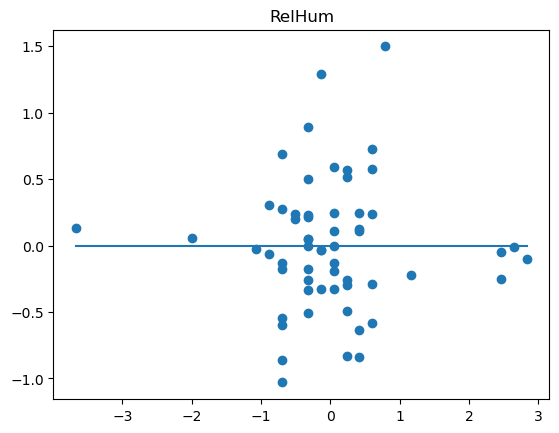

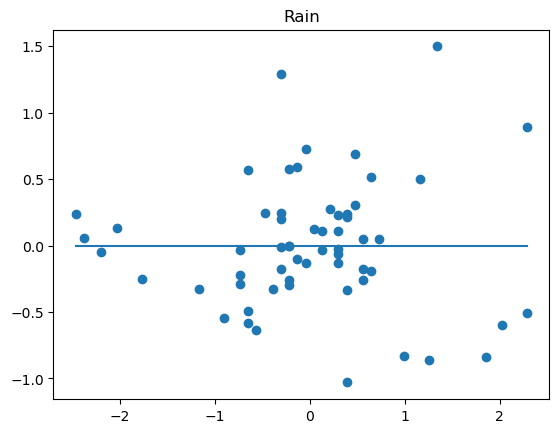

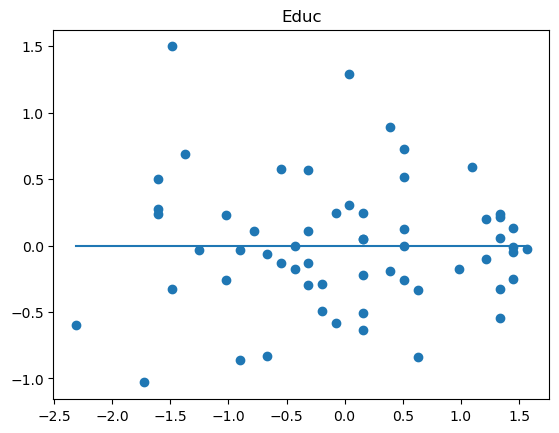

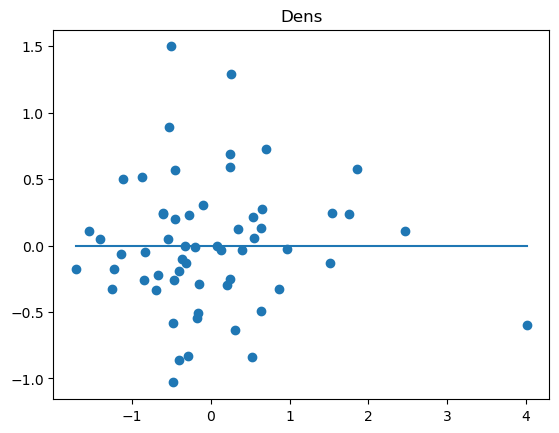

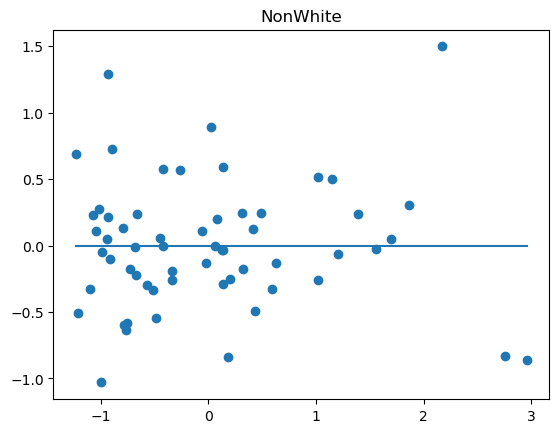

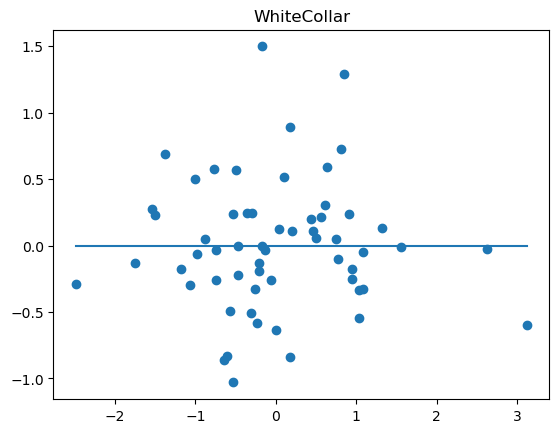

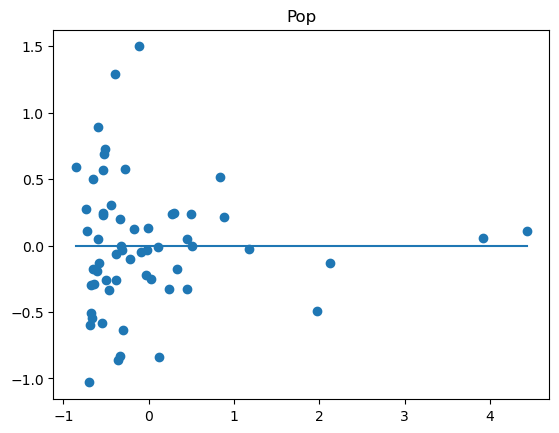

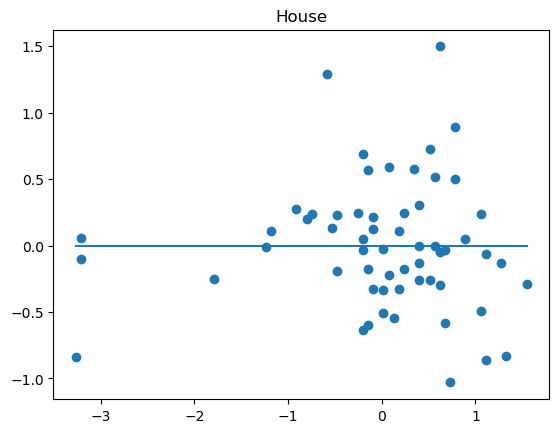

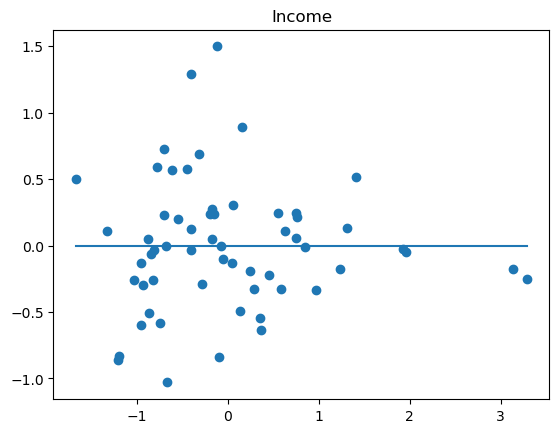

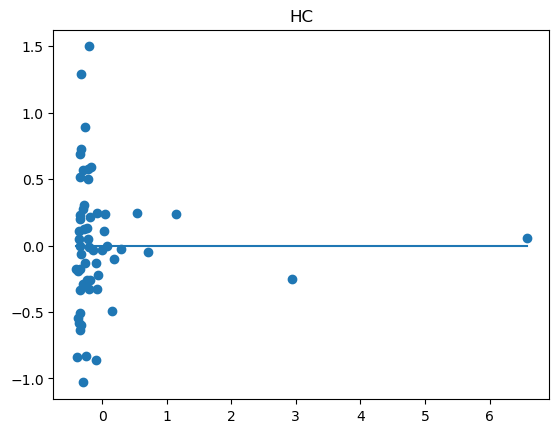

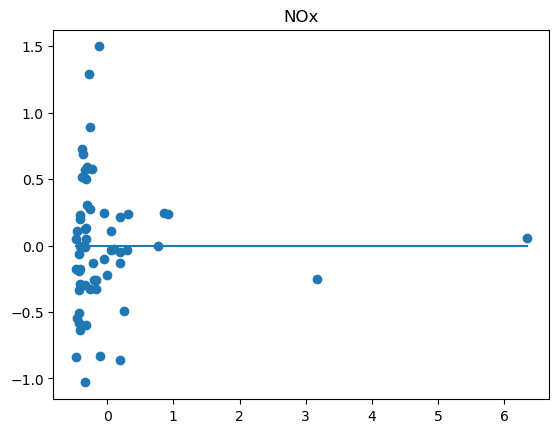

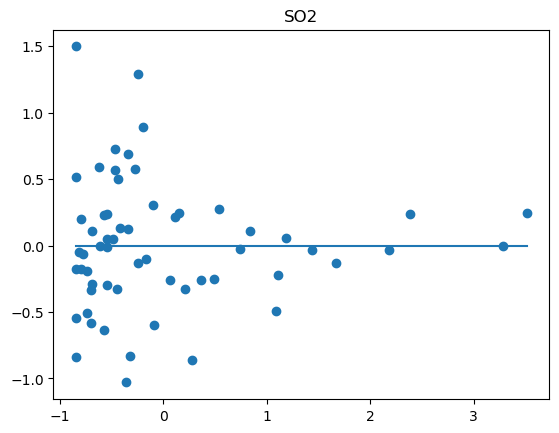

In [8]:
# Here we plot the residuals, so assess the quality of the fit
for i, f in enumerate([ f for f in m_fields if f != 'Mortality']):
  plt.plot(sorted(m_X_scaled.T[i]), np.zeros_like(m_Y_scaled))
  plt.scatter(m_X_scaled.T[i], m_Y_scaled - m_X_inter.dot(m_beta_gd))
  plt.title(f)
  plt.show()

BetaHat = [-2.06668016e-16 -3.32705743e-01 -3.98101441e-02  1.11895996e-02
  4.23207574e-01 -1.65683932e-01  1.98548304e-02  5.41098895e-01
 -1.32119883e-01  7.54582762e-02 -4.38557723e-02 -8.07253329e-02
 -2.73881009e-01  6.84247348e-01 -1.04589350e-01]
Final loss value = 15.390076963688447


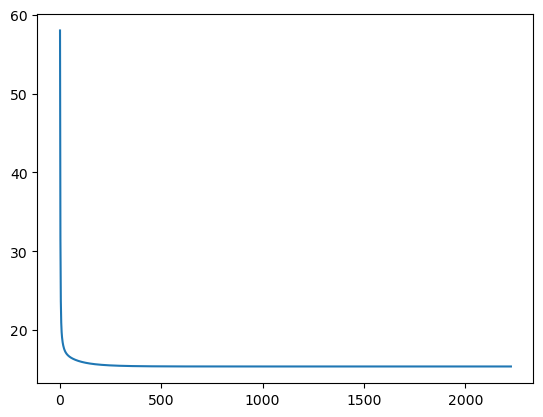

In [9]:
# From the residuals, and the Q-Q plots, we find the following variables deviate significantly from normality: ['NonWhite','Pop','HC','NOx','SO2']
# So we perform a log transform on the _non-scaled_ values

m_X_transformed = np.array([ m_values[f] if f not in ['NonWhite','Pop','HC','NOx','SO2'] else np.log(m_values[f]) for f in m_fields ]).T
m_X_transformed = m_X_transformed[:,1:] # (Feb 18) updated to exclude dependent variable "Mortality"

# After the transform, we then rescale all variables accroding to the new means and standard deviations
m_X_transformed_scaled = (m_X_transformed - m_X_transformed.mean(axis=0))/m_X_transformed.std(axis=0, ddof=1)
m_X_ts_inter = add_intercept(m_X_transformed_scaled) 
# Then perform the gradient descent again
m_beta_gd, m_losses = gradient_descent(m_X_ts_inter, m_Y_scaled, 0.001, 1e-6, max_iter=100000)
print("BetaHat = {}".format(m_beta_gd))
print("Final loss value = {}".format(m_losses[-1]))
plt.plot(range(len(m_losses)), m_losses)
plt.show()

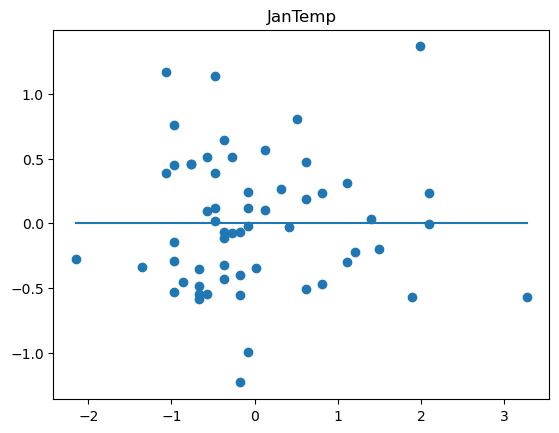

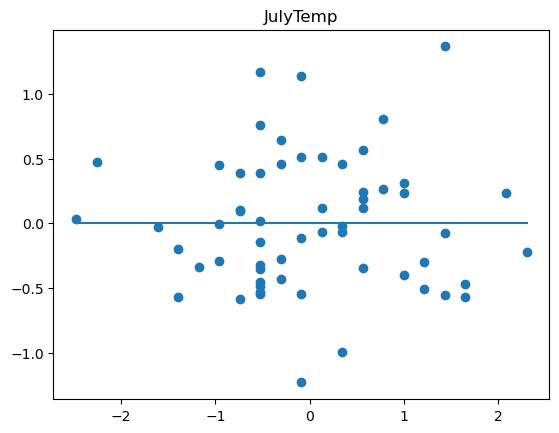

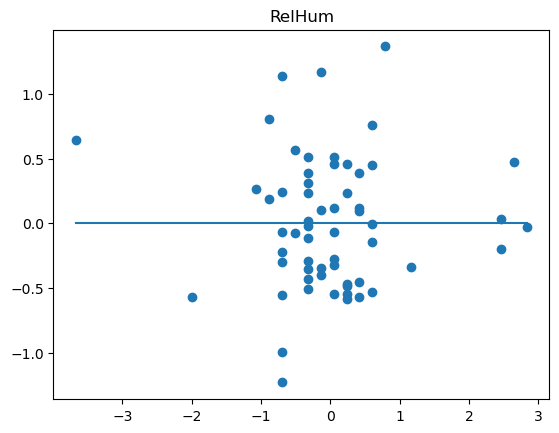

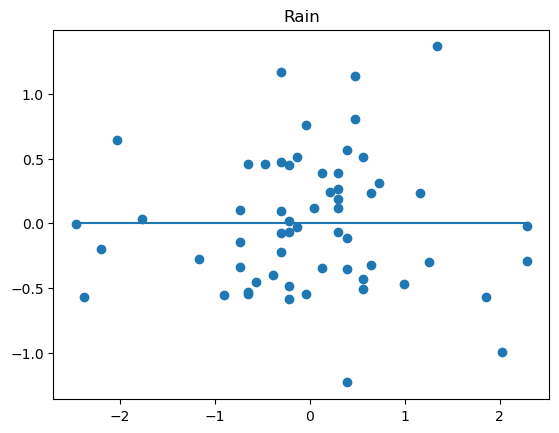

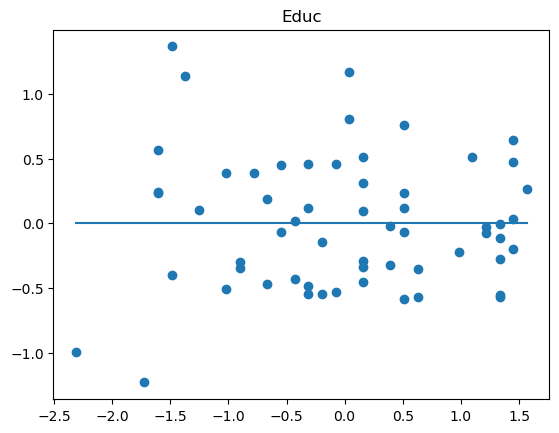

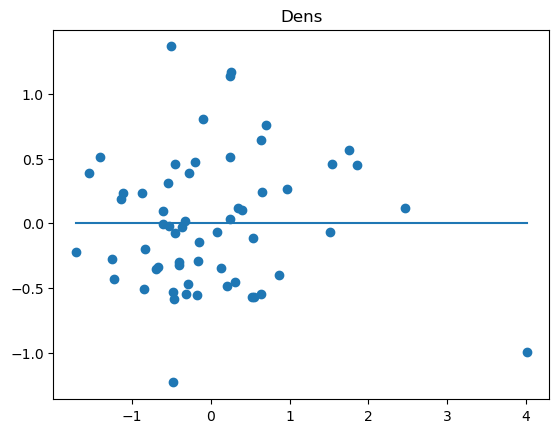

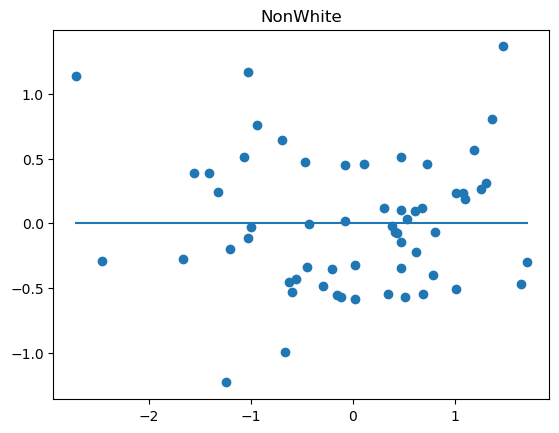

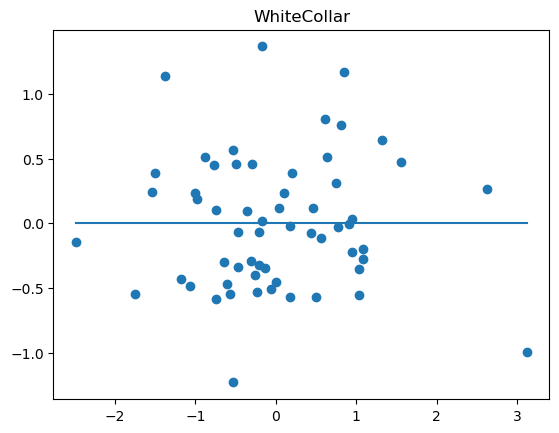

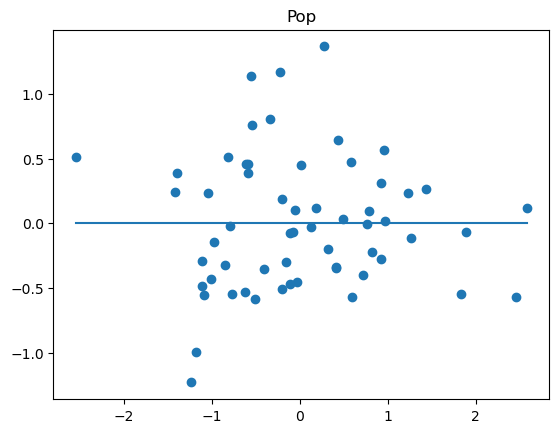

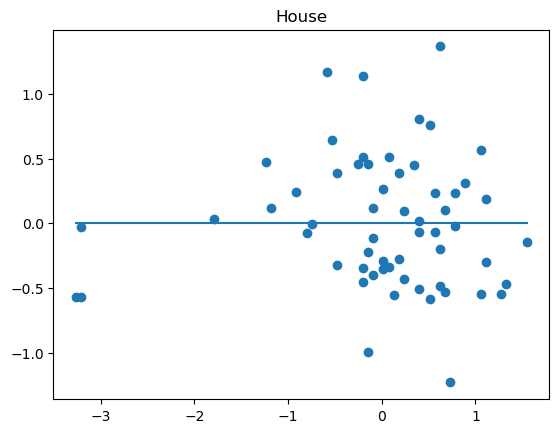

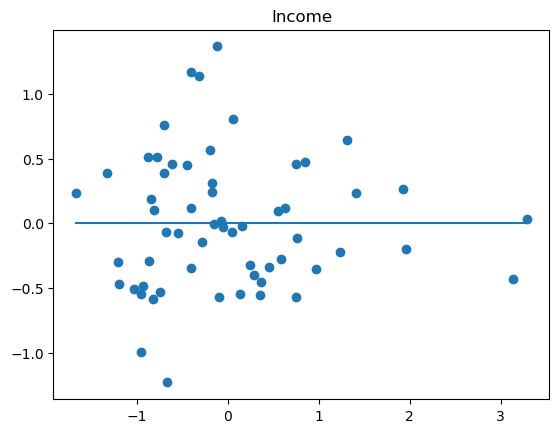

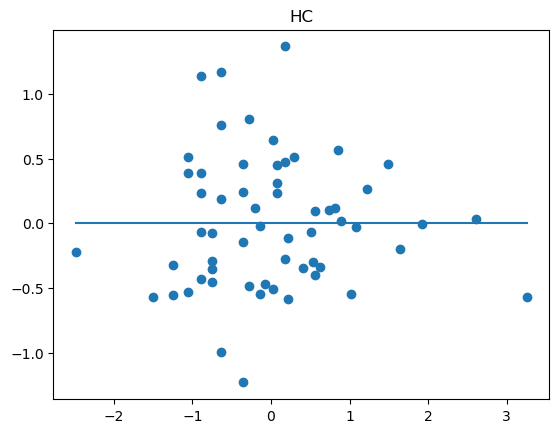

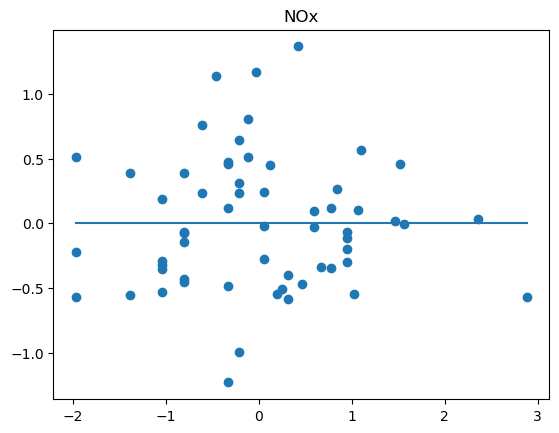

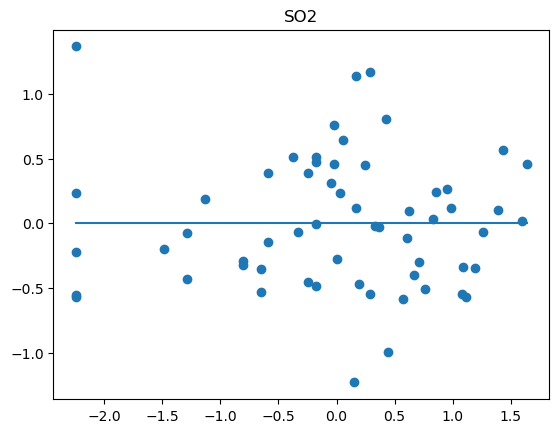

In [10]:
# We can also plot the residuals again, and we see that they are also improved.
for i, f in enumerate([ f for f in m_fields if f != 'Mortality']):
  plt.plot(sorted(m_X_transformed_scaled.T[i]), np.zeros_like(m_Y_scaled))
  plt.scatter(m_X_transformed_scaled.T[i], m_Y_scaled - m_X_ts_inter.dot(m_beta_gd))
  plt.title(f)
  plt.show()

### Appendix A: explanation on why log transformation would cause increasing loss (Feb 18)

1. The log transformation on the features based on qq-plot and residual-plot is really important. Given the model (linear model here) we have, this skill is really important and will benefit you in your future real life data analysis. In this sense, the answers here are correct, i.e., we should do log transformation on such features like non-white, SO2, etc.

2. However, why we improve the model based on the log transformation but the loss do increase (from 13 to 15)? This results from that the model is not accurate enough; whether the log transformation (or whatever the transformation you want) will cause loss higher or not depends on your model.

    1. If the model is accurate enough, say the ground truth is $Y = \beta_0 + \beta_1 X_1 + \beta_2 \log(X_2)$, and your model is just $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2$. Of course, after training, you will have a not bad but not satisfying result. Then you check the qq-plot and residual-plot for each independent feature ($X_1$ and $X_2$ here), and you decide to perform a log transformation on $X_2$. So your improved model is $Y = \beta_0 + \beta_1 X_1 + \beta_2 \log(X_2)$, which is exactly the ground truth. Consequently, we will have a lower loss.
    
    2. If the model is not accurate enough, say the ground truth (data) is $Y = \beta_0 + \beta_1 X_1^2 + \beta_2  sin(X_2) + \beta_3 X_1 \log(X_2) + â€¦$ (you name it), a really nonlinear and complicated relation. In this case, however, if you still model $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2$, then even if you try to improve the model by log transformation based on qq-plot, it is not necessary that the loss will decrease. Both the original model and the improved model are not good enough, far away from the real underlying ground truth; hardly can we predict that the log transformation on some features can bring the loss lower.

In short, the fact that we recommend people do transformation on features is under two assumptions:
1. We use linear model and linear model is good enough to capture the ground truth information.
2. The linear model obey the normality assumption.

In other words, if we use linear model and make transformation to obey the normality assumption, but the linear model is far away from the ground truth, there is no guarantee that such improvement will decrease the loss. The next step for people is to examine and re-build your model (like neural network, etc.) But again, within/constrained by the framework of linear model, checking qq-plot and residual-plot and performing transformation on some features is really a good skill you want to master, making your toolbox more powerful for your future data analysis in the real life.

### Appendix B: compare X and add_intercept(X) in training process (Feb 18)

For 1D model, generate data.

Model 1: $Y = \beta_0 + \beta_1 X$

Model 2: $Y = \beta_2 X$

For model 1, we would expect the $\hat{\beta} \approx (10, 3)$, where $\hat{\beta}$ is the converging parameters after training using gradient descent.

**Though model 2 is not correct, we want to investigate if optimal iterations \& step_size in the two models are different or not**

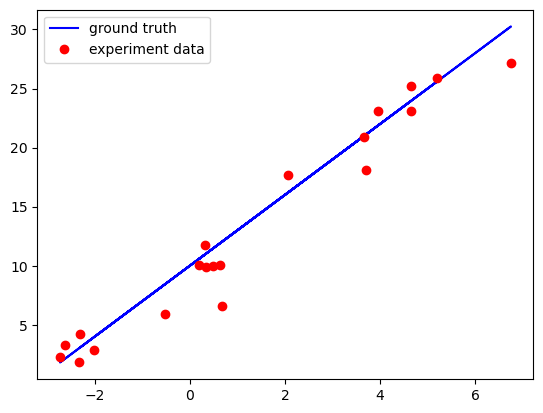

In [43]:
n = 20

X_true = np.random.rand(20) * 10.0 - 3.0
Y_true = 3 * X_true + 10



X = X_true
Y_noise = np.random.randn(n) * 2
Y = Y_true + Y_noise
plt.figure()
plt.plot(X_true, Y_true, 'b-', label = "ground truth")
plt.plot(X_true, Y, 'ro', label = "experiment data")
plt.legend(loc = "upper left")
plt.show()

In [44]:
X = np.reshape(X,(n,1))
Y = np.reshape(Y,(n,1))
X

array([[ 0.66898817],
       [ 4.6491543 ],
       [ 2.06762751],
       [-2.30282936],
       [ 0.63537102],
       [ 6.75049767],
       [ 4.65608078],
       [ 3.94686203],
       [-2.01207432],
       [ 0.31854339],
       [-0.51715641],
       [-2.72847217],
       [-2.61475242],
       [-2.3309072 ],
       [ 3.66038682],
       [ 5.197313  ],
       [ 0.33430727],
       [ 0.19723791],
       [ 3.6950156 ],
       [ 0.48842751]])

In [45]:
def gradient_descent(Xs, y, step_size, precision):
    beta = np.zeros_like(Xs[:1,:].T)
    target = (y - Xs @ beta).T @ (y - Xs @ beta)
    update = (2*(y - Xs @ beta).T @ (-Xs)).T
    
    precision = np.linalg.norm(step_size * update)
    iterations = 0
    while (precision > 1e-6) and (iterations < 1e6):
        beta -= step_size * update 
        update = (2*(y - Xs @ beta).T @ (-Xs)).T
        precision = np.linalg.norm(step_size * update)
        iterations += 1
        
    return beta, iterations

In [46]:
def add_intercept(X):
    intercept = np.ones_like(X[:, :1])
    result = np.concatenate((intercept, X), axis = 1)
    
    return result

In [74]:
# step_sizes = np.logspace(-4,-1,7)
# step_sizes

step_sizes = np.linspace(1e-3, 7e-3, 61)
step_sizes

array([0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017,
       0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024, 0.0025,
       0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032, 0.0033,
       0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039, 0.004 , 0.0041,
       0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047, 0.0048, 0.0049,
       0.005 , 0.0051, 0.0052, 0.0053, 0.0054, 0.0055, 0.0056, 0.0057,
       0.0058, 0.0059, 0.006 , 0.0061, 0.0062, 0.0063, 0.0064, 0.0065,
       0.0066, 0.0067, 0.0068, 0.0069, 0.007 ])

#### Model 1 (with intercept)

In [75]:
Xs = add_intercept(X)
Xs

array([[ 1.        ,  0.66898817],
       [ 1.        ,  4.6491543 ],
       [ 1.        ,  2.06762751],
       [ 1.        , -2.30282936],
       [ 1.        ,  0.63537102],
       [ 1.        ,  6.75049767],
       [ 1.        ,  4.65608078],
       [ 1.        ,  3.94686203],
       [ 1.        , -2.01207432],
       [ 1.        ,  0.31854339],
       [ 1.        , -0.51715641],
       [ 1.        , -2.72847217],
       [ 1.        , -2.61475242],
       [ 1.        , -2.3309072 ],
       [ 1.        ,  3.66038682],
       [ 1.        ,  5.197313  ],
       [ 1.        ,  0.33430727],
       [ 1.        ,  0.19723791],
       [ 1.        ,  3.6950156 ],
       [ 1.        ,  0.48842751]])

In [76]:
beta_gds = []
iterations = []
for step_size in step_sizes:
    beta_gd, iteration = gradient_descent(Xs, Y, step_size, 1e-6)
    print(iteration)
    beta_gds.append(beta_gd)
    iterations.append(iteration)
    #beta_gd
beta_gds = np.array(beta_gds)
iterations = np.array(iterations)

375
343
316
293
273
256
241
227
215
204
195
186
178
170
163
157
151
146
141
136
131
127
123
120
116
113
110
107
104
102
99
97
94
92
90
88
86
99
137
219
510


/var/folders/n2/s7vpqgq50sd0tww3snmdfc7w0000gn/T/ipykernel_9917/171310688.py:10: RuntimeWarning: overflow encountered in matmul
  update = (2*(y - Xs @ beta).T @ (-Xs)).T
/var/folders/n2/s7vpqgq50sd0tww3snmdfc7w0000gn/T/ipykernel_9917/171310688.py:10: RuntimeWarning: invalid value encountered in matmul
  update = (2*(y - Xs @ beta).T @ (-Xs)).T


82184
14993
8389
5888
4572
3760
3208
2809
2506
2269
2078
1921
1789
1677
1581
1497
1424
1358
1300
1248


In [77]:
beta_gds

array([[[ 9.35179247e+000],
        [ 2.94547003e+000]],

       [[ 9.35179523e+000],
        [ 2.94546965e+000]],

       [[ 9.35179740e+000],
        [ 2.94546934e+000]],

       [[ 9.35179926e+000],
        [ 2.94546908e+000]],

       [[ 9.35180070e+000],
        [ 2.94546888e+000]],

       [[ 9.35180238e+000],
        [ 2.94546865e+000]],

       [[ 9.35180381e+000],
        [ 2.94546845e+000]],

       [[ 9.35180439e+000],
        [ 2.94546836e+000]],

       [[ 9.35180540e+000],
        [ 2.94546822e+000]],

       [[ 9.35180610e+000],
        [ 2.94546813e+000]],

       [[ 9.35180766e+000],
        [ 2.94546791e+000]],

       [[ 9.35180826e+000],
        [ 2.94546782e+000]],

       [[ 9.35180902e+000],
        [ 2.94546772e+000]],

       [[ 9.35180906e+000],
        [ 2.94546771e+000]],

       [[ 9.35180944e+000],
        [ 2.94546766e+000]],

       [[ 9.35181026e+000],
        [ 2.94546754e+000]],

       [[ 9.35181057e+000],
        [ 2.94546750e+000]],

       [[ 9.35

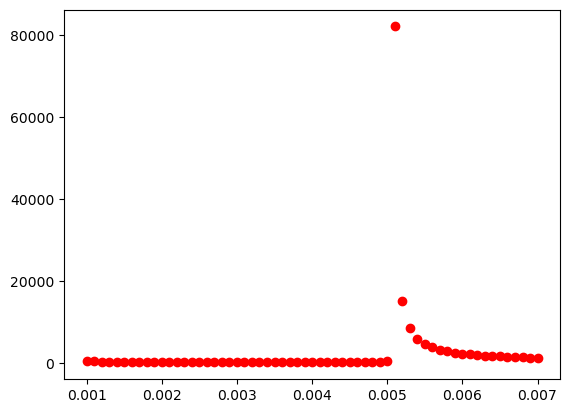

In [78]:
plt.plot(step_sizes, iterations, 'ro')

In [79]:
iteration_min, step_size_opt = iterations[np.argmin(iterations)], step_sizes[np.argmin(iterations)]
iteration_min, step_size_opt

(86, 0.0046)

We get the result for model 1. With intercept, the optimal iterations is 86 with step_size = 0.0046.

#### Model 2 (without intercept)

In [80]:
beta_gds = []
iterations = []
for step_size in step_sizes:
    beta_gd, iteration = gradient_descent(X, Y, step_size, 1e-6)
    print(iteration)
    beta_gds.append(beta_gd)
    iterations.append(iteration)
    #beta_gd
beta_gds = np.array(beta_gds)
iterations = np.array(iterations)

30
26
24
21
19
17
16
14
13
12
11
9
8
7
6
5
3
5
7
8
9
10
11
13
14
15
17
19
21
24
27
30
34
39
45
53
64
80
103
145
235
587
59228
14226
8213
5834
4558
3763
3219
2823
2522
2286
2095
1938
1806
1694
1597
1512
1438
1373
1314


/var/folders/n2/s7vpqgq50sd0tww3snmdfc7w0000gn/T/ipykernel_9917/171310688.py:10: RuntimeWarning: overflow encountered in matmul
  update = (2*(y - Xs @ beta).T @ (-Xs)).T
/var/folders/n2/s7vpqgq50sd0tww3snmdfc7w0000gn/T/ipykernel_9917/171310688.py:9: RuntimeWarning: invalid value encountered in subtract
  beta -= step_size * update


In [81]:
beta_gds

array([[[4.14237168]],

       [[4.14237115]],

       [[4.14237213]],

       [[4.14237168]],

       [[4.14237191]],

       [[4.14237182]],

       [[4.14237261]],

       [[4.14237217]],

       [[4.14237266]],

       [[4.14237293]],

       [[4.1423731 ]],

       [[4.14237224]],

       [[4.14237243]],

       [[4.14237261]],

       [[4.14237288]],

       [[4.14237327]],

       [[4.14237431]],

       [[4.14237416]],

       [[4.14237354]],

       [[4.14237322]],

       [[4.14237372]],

       [[4.14237301]],

       [[4.142374  ]],

       [[4.14237366]],

       [[4.14237302]],

       [[4.14237414]],

       [[4.14237395]],

       [[4.14237391]],

       [[4.14237397]],

       [[4.14237305]],

       [[4.14237379]],

       [[4.14237297]],

       [[4.14237295]],

       [[4.1423739 ]],

       [[4.14237394]],

       [[4.14237395]],

       [[4.14237292]],

       [[4.14237297]],

       [[4.14237395]],

       [[4.14237392]],

       [[4.14237394]],

       [[4.14237

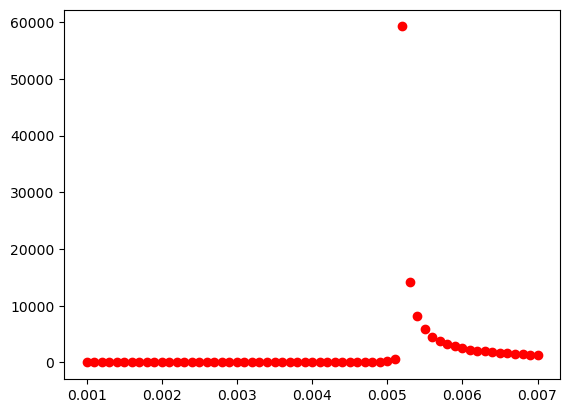

In [82]:
plt.plot(step_sizes, iterations, 'ro')

In [83]:
iteration_min, step_size_opt = iterations[np.argmin(iterations)], step_sizes[np.argmin(iterations)]
iteration_min, step_size_opt

(3, 0.0026)

We get the result for model 2. Without intercept, the optimal iterations is 3 with step_size = 0.0026.

##### This simulation data is generated randomly. Therefore, each run will give difference answers. But the conclusion remain unchanged, i.e., opt_iters and step_size are different in two models.

In [5]:
prechange = [-3.36488394e-16, -2.34377091e-01, -2.17496828e-01, 1.17238925e-02,
             1.79754504e-01, -1.50544513e-01, 1.08945825e-01, 7.64348559e-01,
             -1.21202349e-01, 8.40325965e-02, -1.11479218e-01, -3.04687337e-02,
             -9.96190618e-01, 8.81043305e-01,  8.61146149e-02]
prechange

[-3.36488394e-16,
 -0.234377091,
 -0.217496828,
 0.0117238925,
 0.179754504,
 -0.150544513,
 0.108945825,
 0.764348559,
 -0.121202349,
 0.0840325965,
 -0.111479218,
 -0.0304687337,
 -0.996190618,
 0.881043305,
 0.0861146149]

In [10]:
afterchange = [-2.03960936e-16, -3.32706173e-01, -3.98138808e-02, 1.11889532e-02, 
               4.23207218e-01, -1.65683213e-01,  1.98542624e-02,  5.41101211e-01,
               -1.32119323e-01, 7.54577007e-02, -4.38575359e-02, -8.07265482e-02,
               -2.73899623e-01, 6.84266675e-01, -1.04592675e-01]

In [11]:
afterchange

[-2.03960936e-16,
 -0.332706173,
 -0.0398138808,
 0.0111889532,
 0.423207218,
 -0.165683213,
 0.0198542624,
 0.541101211,
 -0.132119323,
 0.0754577007,
 -0.0438575359,
 -0.0807265482,
 -0.273899623,
 0.684266675,
 -0.104592675]